# Numerical Modeling

_Reference:_ [12 steps to Navier-Stokes](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/).

Given the broad topics of "Modeling" and "Statistics" for a 1-hour lecture, I could think of no better way than for one, recently introduced into the Python language, to build a numerical model from scratch using the core language and utilities. Once derived, this model will present itself to perturbations, extensions, and of course comparisons (i.e., statistics) with other models.

__Objective:__ Create numerical model(s) and briefly compare with expected solution.

## Step 1: Linear Convection

$$\frac{\partial{u}}{\partial{t}} + c\frac{\partial{u}}{\partial{x}} = 0\text{,}\hspace{12pt}\text{the 1-D Linear Convection equation.}$$

This equation above represents a wave uniformly propagating (not changing shape in time) with a speed of $c$. We then can describe the initial wave as

__Initial Condition (wave):__$u(x,0) = u_0(x)$

For the sake of simplicity,

__Exact Solution:__ $u(x,t) = u_0(x-ct)$

But, what if this equation was something worse? How can knowing Python help us? A part of modeling is being able approximate the solution using finite difference schemes. Going back to the definition of a derivative (and removing the limit):

$$\frac{\partial{u}}{\partial{x}} \approx \frac{u(x+\Delta x)-u(x)}{\Delta x}$$

We then can show that the discrete version of our 1-D convection equation is

$$\frac{u_i^{n+1}-u_i^n}{\Delta t}+c\frac{u_i^n-u_{i-1}^n}{\Delta x} = 0$$

noting that we use a Forward Difference scheme for $t$ and a Backward Difference scheme for $x$. We then rearrange to solve for the next velocity in time (i.e., $u^{n+1}$):

$$u_i^{n+1} = u_i^n - c\frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)\text{,}\hspace{10pt}\text{n=time, i=space}$$

or, we could write it as the following:

$$u(x,t+\Delta t) = u(x,t) - c\frac{\Delta t}{\Delta x}[u(x,t)-u(x-\Delta x, t)]$$

Time for some Python!

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# spatial grid
nx = 41 # try changing from 41 to 81
dx = 2./(nx-1) #dx = delta x
nt = 20
dt = nt/1000. #dt = delta t
c = 1. # wavespeed

We need to give an initial wave which is a function of $x$ (remember, $u(x,0)=u_0(x)$). We can easily choose a step-function for the velocity:

$$u(x,0) = u_0(x) = \left\{\begin{array}{ll}2 & : 0.5 \le x \le 1 \\ 1 & : \text{elsewhere  in }(0,2)\end{array}\right\}$$

Let's see this in Python!

In [38]:
u = np.ones(nx)
u[.5/dx : 1./dx+1] = 2
print u

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]


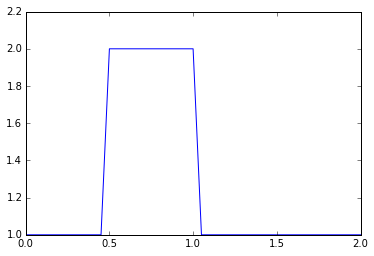

In [39]:
#visually
plt.plot(np.linspace(0, 2, nx), u);

### Breakout:

Why does this step-function (our initial velocity), have slanted lines? (__Hint:__ What is the numpy linspace producing?)

---

Now, let's apply our finite-difference schemes to the convection equation given our new initial conditions to solve for our new velocity after some time has elapsed.

In [40]:
un = np.ones(nx) #temporary n-th velocity array

for n in range(nt):
    un = u.copy() # store the previous time-step's values
    for i in range(1,nx):
    #for i in range(nx): # next breakout question
        u[i] = un[i] - c*(dt/dx)*(un[i] - un[i-1])

__Note:__ This routine is actually quite inefficient, but we can improve this later.

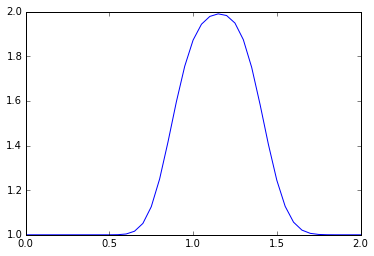

In [41]:
plt.plot(np.linspace(0, 2, nx), u);

### Breakout:

What happens when we change the second _for_ loop to the other one? Why did we have to start at i=1?

---

### (Extra) Breakout:

What happens to the wave if we repeat the calculation for $u$ and plot? Can you explain why this is so? Try changing the parameters to make the wave go backwards.

---

### (Extra! Extra!) Breakout:

If we change nx to 81, what happens to our $u$ plot after it advances in time?

## Step 2: Non-linear Convection

Non-linear convection only changes the constant velocity to a varying velocity (i.e., $c \rightarrow u$).

$$\frac{\partial{u}}{\partial{t}} + u\frac{\partial{u}}{\partial{x}} = 0$$

Using the same discretization schemes as in Step 1, forward diff for time and backward diff for space, we have the following discretization equation:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t}+u_i^n\frac{u_i^n-u_{i-1}^n}{\Delta x} = 0$$

yielding for the $u_i^{n+1}$ term:

$$u_i^{n+1} = u_i^n - u_i^n\frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

## Homework:

The rest of this section is left up to you. Revise our _for loop_ to include now that velocity term for the non-linear convection discretized equation to produce a similar plot like below.

<img src="hw1.png">

## Step 3: CFL Condition

In [42]:
def linearconv(nx):
    dx = 2./(nx-1)
    nt = 20
    dt = 0.025
    c = 1.
    
    u = np.ones(nx)
    u[.5/dx : 1/dx+1] = 2
    
    un = np.ones(nx)
    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i] - c*(dt/dx)*(un[i] - un[i-1])
            
    plt.plot(np.linspace(0,2,nx), u);

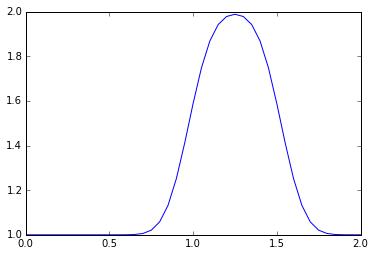

In [43]:
linearconv(41) # 41 grid points, same as Step 1

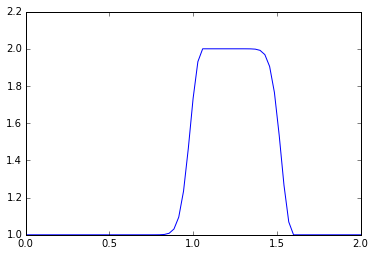

In [44]:
linearconv(71)

### Breakout:

Start changing the number of grid points using our function and see what happens to our wave. What happens when you choose a large number? What happens when you choose a small number?

---

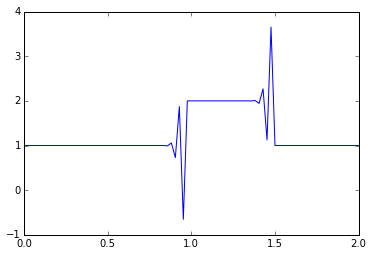

In [45]:
linearconv(85)

Shown above, we see that this does not look like our original step-function wave. What happened? We broke stability (wave travels a distance in one time step, $\Delta t$, that is greater than our spatial step, $dx$). To maintain this, we need to enforce stability:

$$\sigma = \frac{u\Delta t}{\Delta x}\le \sigma_\text{max}$$

$\sigma$ is called the Courant number which $\sigma_\text{max}$ will ensure stability for our wave solution.

In [46]:
def linearconv(nx):
    dx = 2./(nx-1)
    nt = 20
    c = 1.
    sigma = .5 # for nx=41, we get sigma=0.5 from dt/dx = 0.025/(2./(nx-1))
    
    dt = sigma*dx
    
    u = np.ones(nx)
    u[.5/dx : 1/dx+1] = 2
    
    un = np.ones(nx)
    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i] - c*(dt/dx)*(un[i] - un[i-1])
            
    plt.plot(np.linspace(0,2,nx), u);

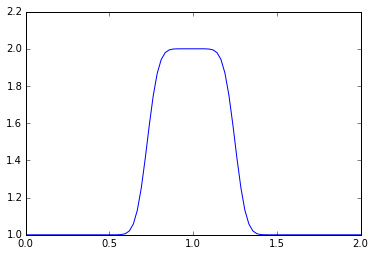

In [47]:
linearconv(85)

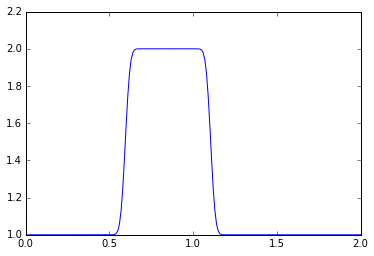

In [48]:
linearconv(201) # as we increase nx, our time window shortens due to a smaller dt

## Step 4: 1-D Diffusion

$$\frac{\partial{u}}{\partial{t}}=\nu\frac{\partial^2{u}}{\partial{x^2}}\text{,}\hspace{12pt}\text{the 1-D Diffusion equation.}$$

Since we now have a second-order differential, and to save some time, the discretized version of the diffusion equation is as follows:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

and then arranged to solve for the only unknown ($u_i^{n+1}$),

$$u_{i}^{n+1}=u_{i}^{n}+\nu\frac{\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

__Note:__ We used the Central Difference scheme on the second-order deriviative which is a combination of the Forward Difference and Backward Difference of the first derivative.

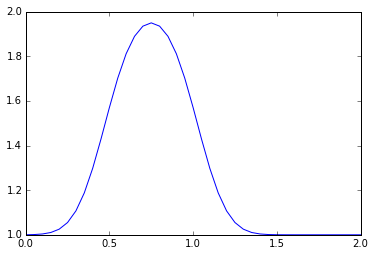

In [49]:
nx = 41
dx = 2./(nx-1)
nt = 20
nu = 0.3 #the value of viscosity
sigma = .2 # notice the different sigma value
dt = sigma*dx**2/nu

u = np.ones(nx)
u[.5/dx : 1/dx+1] = 2

un = np.ones(nx)

for n in range(nt):
    un = u.copy()
    for i in range(1,nx-1):
        u[i] = un[i] + nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
        
plt.plot(np.linspace(0,2,nx), u);

# Step 5: Burgers' Equation

$$\frac{\partial{u}}{\partial{t}}+u\frac{\partial{u}}{\partial{x}}=\nu\frac{\partial^2{u}}{\partial{x^2}}\text{,}\hspace{12pt}\text{Burgers' equation.}$$

which is a combination of non-linear convection and diffusion. Once again, we will draw from previous discretizations to obtain our discretized differential equation:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Yet again solving for the unknown $u_i^{n+1}$

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

Whew! That looks scary, right?

---

Our initial condition for this problem is going to be:

\begin{eqnarray}
u(x,0) &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}

This has an analytical solution, given by:

\begin{eqnarray}
u(x,t) &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

Our boundary condition will be:

$$u(0) = u(2\pi)$$

This is called a *periodic* boundary condition. Pay attention! This will cause you a bit of headache if you don't tread carefully.

#### Aside: SymPy

To save some time and frustrations, we are going to use a symbolic math library for Python. Let's explore it some:

In [50]:
import numpy as np
import sympy

from sympy import init_printing
init_printing(use_latex=True) # output to be rendered as LaTeX

In [51]:
x,nu,t = sympy.symbols('x nu t')
phi = sympy.exp(-(x-4*t)**2/(4*nu*(t+1))) + sympy.exp(-(x-4*t-2*np.pi)**2/(4*nu*(t+1)))
phi

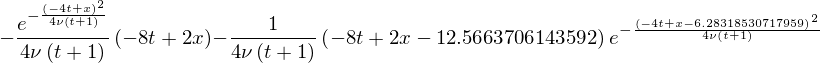

In [52]:
phiprime = phi.diff(x)
phiprime

In [53]:
print phiprime # shows Pythonic version

-(-8*t + 2*x)*exp(-(-4*t + x)**2/(4*nu*(t + 1)))/(4*nu*(t + 1)) - (-8*t + 2*x - 12.5663706143592)*exp(-(-4*t + x - 6.28318530717959)**2/(4*nu*(t + 1)))/(4*nu*(t + 1))


In [54]:
from sympy.utilities.lambdify import lambdify

u = -2*nu*(phiprime/phi)+4

# we are sending variables to a function
ufunc = lambdify((t, x, nu), u)
print ufunc(1,4,3)

3.49170664206


#### Continued: Burgers' Equation

In [55]:
###variable declarations
nx = 101
nt = 100
dx = 2*np.pi/(nx-1)
nu = .07
dt = dx*nu

x = np.linspace(0, 2*np.pi, nx)
un = np.empty(nx)
t = 0

u = np.asarray([ufunc(t, x0, nu) for x0 in x])
u

array([ 4.        ,  4.06283185,  4.12566371,  4.18849556,  4.25132741,
        4.31415927,  4.37699112,  4.43982297,  4.50265482,  4.56548668,
        4.62831853,  4.69115038,  4.75398224,  4.81681409,  4.87964594,
        4.9424778 ,  5.00530965,  5.0681415 ,  5.13097336,  5.19380521,
        5.25663706,  5.31946891,  5.38230077,  5.44513262,  5.50796447,
        5.57079633,  5.63362818,  5.69646003,  5.75929189,  5.82212374,
        5.88495559,  5.94778745,  6.0106193 ,  6.07345115,  6.136283  ,
        6.19911486,  6.26194671,  6.32477856,  6.38761042,  6.45044227,
        6.51327412,  6.57610598,  6.63893783,  6.70176967,  6.76460125,
        6.82742866,  6.89018589,  6.95176632,  6.99367964,  6.72527549,
        4.        ,  1.27472451,  1.00632036,  1.04823368,  1.10981411,
        1.17257134,  1.23539875,  1.29823033,  1.36106217,  1.42389402,
        1.48672588,  1.54955773,  1.61238958,  1.67522144,  1.73805329,
        1.80088514,  1.863717  ,  1.92654885,  1.9893807 ,  2.05

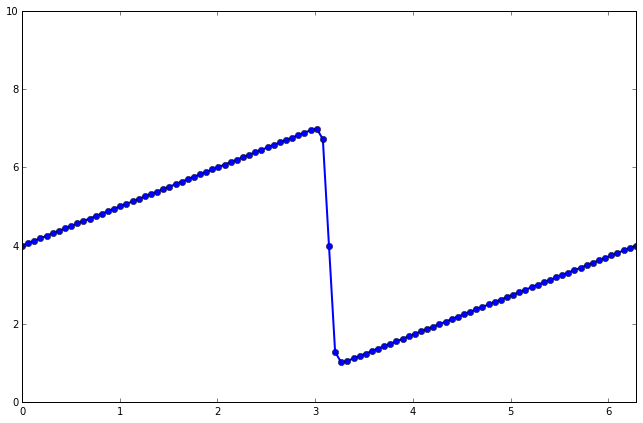

In [56]:
plt.figure(figsize=(11,7), dpi=100)
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0,2*np.pi])
plt.ylim([0,10]);

This is a "saw-tooth function" to which we have applied our periodic boundary conditions. Steps 1 & 2 continually move the plot off the screen, but with periodic boundary conditions, it will wrap around to the front again.

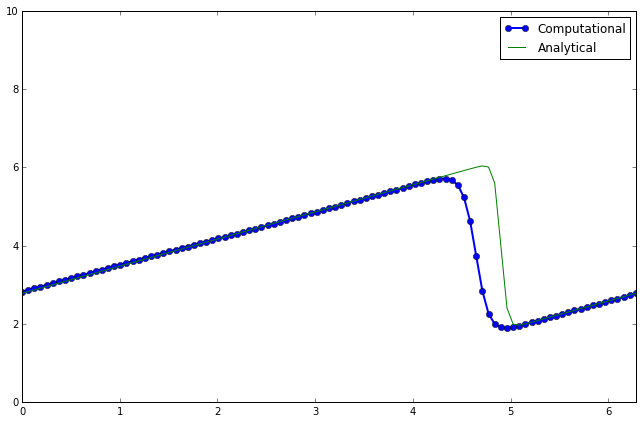

In [57]:
for n in range(nt):
    un = u.copy()
    for i in range(nx-1):
        u[i] = un[i] - un[i] * dt/dx *(un[i] - un[i-1]) + nu*dt/dx**2*\
                (un[i+1]-2*un[i]+un[i-1])
    u[-1] = un[-1] - un[-1] * dt/dx * (un[-1] - un[-2]) + nu*dt/dx**2*\
                (un[0]-2*un[-1]+un[-2])
        
u_analytical = np.asarray([ufunc(nt*dt, xi, nu) for xi in x])

plt.figure(figsize=(11,7), dpi=100)
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0,2*np.pi])
plt.ylim([0,10])
plt.legend();

## Extra Homework!

Use the same technique to plot the Computational (discretized model) and the Analytical (exact) solutions of the original 1-D linear convection equation.